In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint,solve_ivp

## 1) Data

In [2]:
def F(t,x,sigma=10,b=8/3,r=28):
 F1 = sigma*(x[1]-x[0])
 F2 = r*x[0] - x[1] - x[0]*x[2]
 F3 = x[0]*x[1] - b*x[2]
 return np.array([F1,F2,F3])

In [3]:
dt = 0.02
T = 200
N = int(T/dt)
times = np.linspace(0,T,N)

10000
(3, 10000)


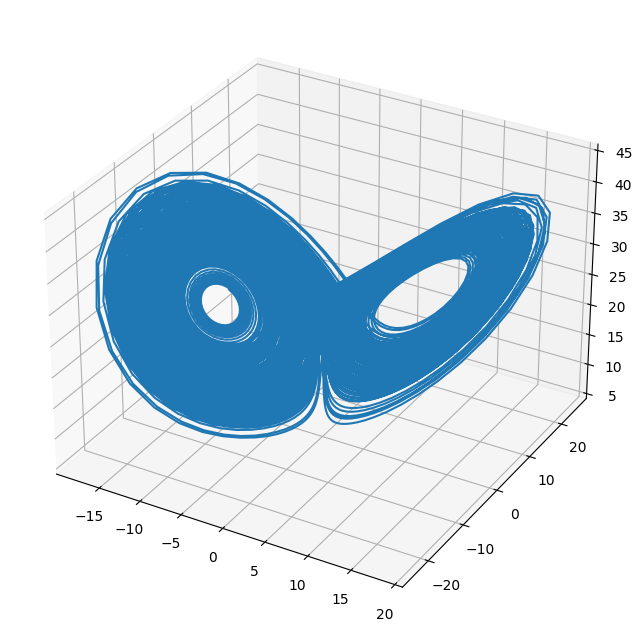

In [4]:
plt.rcParams['figure.figsize'] = [8, 8]
X0 = np.array([[0.1,0.1,0.1]]) #,[0.1,0.1,0.1],[-0.2,0.1,0.1],[-3,-3,0],[-10,-10,1]])
ax = plt.axes(projection='3d')
N0 = int(5/dt)

for i in range(len(X0)):
 solution = solve_ivp(F, [0,T], X0[i], t_eval=times) #odeint(F,X0[i],times)
 times = solution.t
 print(len(times))
 sol = solution.y
 ax.plot3D(sol[0,N0:],sol[1,N0:],sol[2,N0:],color="C0")
 X = sol

print(np.array(X).shape)

# Reservoir Computing

In [5]:
class Reservoir:

    def __init__(self,in_out_dim=3, rho=1.1, n_neurons=300):
        self.in_out_dim = in_out_dim
        self.n_neurons = n_neurons

        A = np.random.uniform(low=-1,high=1, size=(self.n_neurons,self.n_neurons)) * (np.random.rand(self.n_neurons,self.n_neurons)<0.08).astype(float)
        _,S,_ = np.linalg.svd(A)

        self.W = (A/np.amax(S))*rho

        #other weights
        self.wIN = np.random.uniform(low=-0.3,high=0.3,size=(self.n_neurons,in_out_dim)) #np.random.normal(0,math.sqrt(0.002),[self.n_neurons,in_out_dim])
        self.wOUT = np.zeros((in_out_dim,self.n_neurons)).astype(float) #np.random.normal(0,math.sqrt(0.02),[in_out_dim,self.n_neurons])

        #initialize memory
        self.r = np.zeros([self.n_neurons,1])

    def sigmoid(self,x):
      return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

    def step(self,x):
        x = np.array(x).reshape([self.in_out_dim,1])
        self.r = self.sigmoid(np.matmul(self.W,self.r)+np.matmul(self.wIN,x))
        O = np.matmul(self.wOUT,self.r)

        return O

    def clear_memory(self):
        self.r = np.zeros([self.n_neurons,1])

    def train(self,X,verbose=False):
        k = 0.000001
        T = X.shape[1]-1

        R = np.zeros([self.n_neurons,self.n_neurons])
        Q = np.zeros([self.n_neurons,self.in_out_dim])

        for t in range(0,T):
            if verbose:print("\riteration:{}/{}".format(t+1,T),end='')
            Yt = np.array(X[:,t+1]).reshape([self.in_out_dim,1])
            Ot = self.step(X[:,t])

            R += np.matmul(self.r,self.r.transpose())
            Q += np.matmul(self.r,Yt.transpose())
        if verbose:
            print()
            print("computing...")

        self.wOUT = np.matmul(np.linalg.inv(R+k*np.eye(self.n_neurons)),Q).transpose()
        if verbose:print('done!')


## Reservoir on x,y,z

In [21]:
dt = 0.02
T = 200
times = np.arange(0,T,dt)
sol = solve_ivp(F, [0,T], [1,1,1], t_eval=times)
X = sol.y

#90%
split_indx = int(len(times)*0.9)
times_train = times[:split_indx]
X_train = X[:,:split_indx]
print(len(times_train))


times_val = times[split_indx:]
X_val = X[:,split_indx:]
print(len(times_val))

print(X_train[:,-2000])
print(len(X_train[0,-2000:]))

9000
1000
[-5.64309449  4.83547254 34.71395919]
2000


In [10]:
def max_predicted_time(y,y_obs,d=1,tol=4):
  max_T = 0
  for max_T in range(y.shape[d]):
    if d == 0:
       if np.abs(y[max_T] - y_obs[max_T]).max() > tol:
        break
    else:
       if np.abs(y[:,max_T] - y_obs[:,max_T]).max() > tol:
        break
  return max_T*dt

In [31]:
#define and train on data
res = Reservoir(rho=0.001)
_,S,_ = np.linalg.svd(res.W)
print(f"Singular value of memory layer:{S.max():.3f}")
res.clear_memory()
res.train(X_train,verbose=True)

Singular value of memory layer:0.001
iteration:8999/8999
computing...
done!


accordance up to:7.46


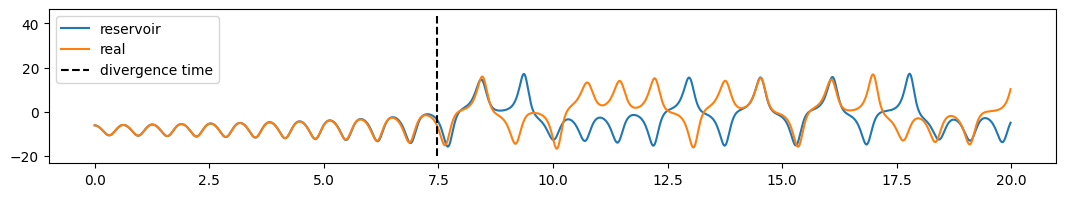

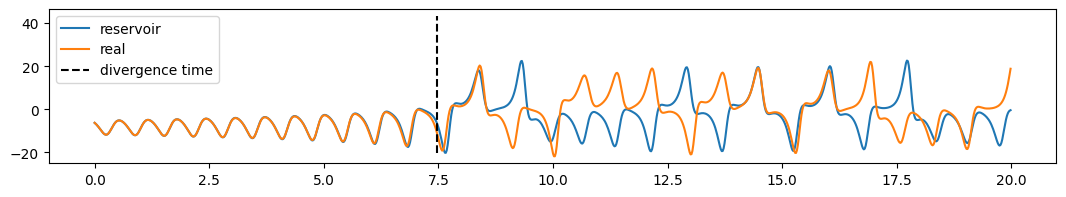

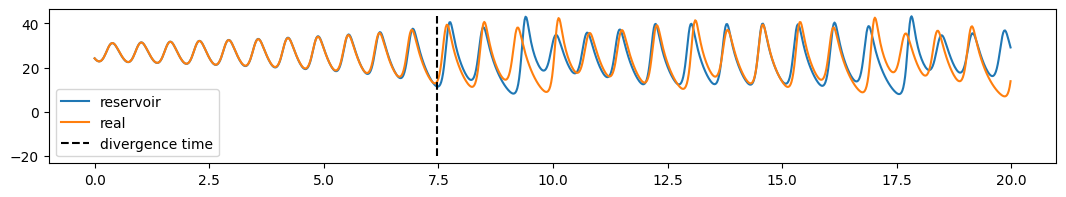

In [32]:
plt.rcParams['figure.figsize'] = [13, 2]

X_pred = np.zeros(X_val.shape)
X_pred[:,0] = X_val[:,0]
for t in range(1,X_pred.shape[1]):
  X_pred[:,t] = res.step(X_pred[:,t-1]).reshape(3)

predicted_time = max_predicted_time(X_pred,X_val)
print(f"accordance up to:{predicted_time}")

max_T = 20
I = np.arange(0,max_T,dt)
for d in range(3):
  plt.plot(I,X_pred[d,:int(max_T/dt)],label="reservoir")
  plt.plot(I,X_val[d,:int(max_T/dt)],label="real")
  plt.plot(predicted_time*np.ones(2), [X_pred.min(),X_pred.max()],'k--', label="divergence time")
  plt.legend()
  plt.show()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
np.save('/content/drive/MyDrive/AdvancedNN/Project/reservoir_lorenz.npy',X_pred)

Mounted at /content/drive


# 3) Reservoir on x

In [ ]:
dimension = 1
res_1d = Reservoir(rho=0.05,in_out_dim=1)
_,S,_ = np.linalg.svd(res_1d.W)
print(f"Singular value of memory layer:{S.max()}")
res_1d.train(X_train[dimension,:].reshape([1,X_train.shape[1]]),verbose=True)

Singular value of memory layer:0.05000000000000001
iteration:8999/8999
computing...
done!


<ipython-input-24-a53b0ea38667>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_pred[t] = res_1d.step(x_pred[t-1])


accordance up to:0.2


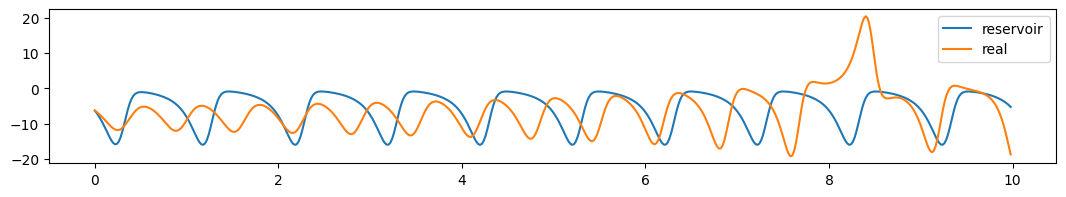

In [ ]:
#es.clear_memory()
x_pred = np.zeros([X_val.shape[1]])
x_pred[0] = X_val[dimension,0]
for t in range(1,x_pred.shape[0]):
  x_pred[t] = res_1d.step(x_pred[t-1])

predicted_time = max_predicted_time(x_pred,X_val[dimension,:],d=0)
print(f"accordance up to:{predicted_time}")

max_T = 10
I = np.arange(0,max_T,dt)
plt.rcParams['figure.figsize'] = [13, 2]


plt.plot(I,x_pred[:int(max_T/dt)],label="reservoir")
plt.plot(I,X_val[dimension,:int(max_T/dt)],label="real")
plt.legend()
plt.show()


whole dynamic:

<ipython-input-5-fc9a3d255e0b>:20: RuntimeWarning: overflow encountered in exp
  return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
<ipython-input-5-fc9a3d255e0b>:20: RuntimeWarning: invalid value encountered in divide
  return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))


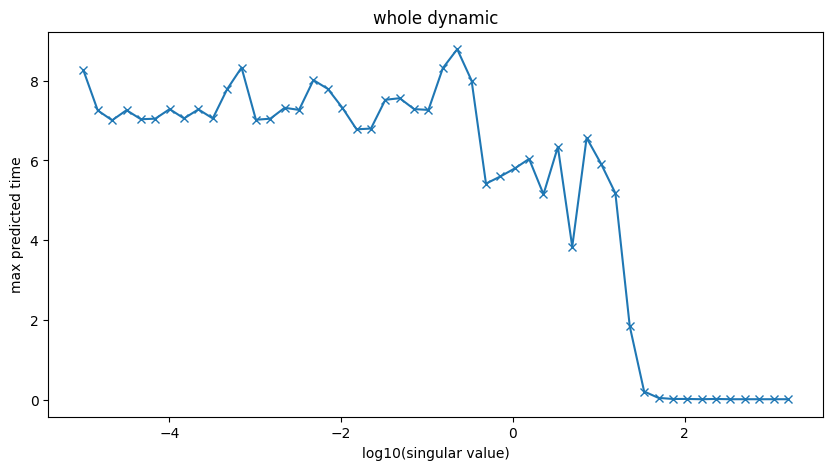

In [ ]:
scaling_factors = np.logspace(-5,3.2,50)
max_pred_times = []
sv_list = []
sv_lowers_list = []

for scaling_factor in scaling_factors:
  val = 0
  n_runs = 3
  for attempt in range(n_runs):
    res = Reservoir(rho=scaling_factor)
    res.clear_memory()
    res.train(X_train,verbose=False)
    _,S,_ = np.linalg.svd(res.W)

    X_pred = np.zeros(X_val.shape)
    X_pred[:,0] = X_val[:,0]
    for t in range(1,X_pred.shape[1]):
      X_pred[:,t] = res.step(X_pred[:,t-1]).reshape(3)

    val += max_predicted_time(X_pred,X_val)

  sv_list.append(S.max())
  sv_lowers_list.append(S.min())
  max_pred_times.append(val/n_runs)

plt.rcParams['figure.figsize'] = [10,5]
plt.title("whole dynamic")
plt.plot(np.log10(sv_list),max_pred_times,marker="x")
plt.xlabel("log10(singular value)")
plt.ylabel("max predicted time")
plt.show()

single variable dynamic:

<ipython-input-43-fbcb69e54f37>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_pred[t] = res_1d.step(x_pred[t-1])
<ipython-input-6-fc9a3d255e0b>:20: RuntimeWarning: overflow encountered in exp
  return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
<ipython-input-6-fc9a3d255e0b>:20: RuntimeWarning: invalid value encountered in divide
  return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))


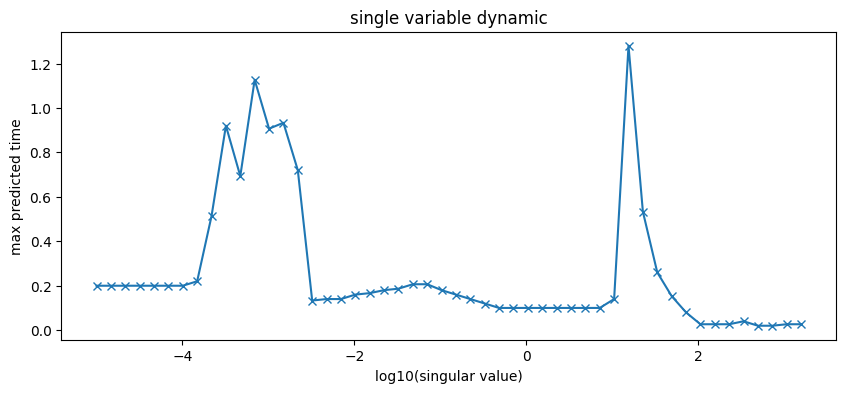

In [ ]:
scaling_factors = np.logspace(-5,3.2,50)
max_pred_times = []
sv_list = []
for scaling_factor in scaling_factors:
  val = 0
  n_runs = 3
  for attempt in range(n_runs):
    dimension = 1
    res_1d = Reservoir(rho=scaling_factor,in_out_dim=1)
    res_1d.train(X_train[dimension,:].reshape([1,X_train.shape[1]]),verbose=False)

    x_pred = np.zeros([X_val.shape[1]])
    x_pred[0] = X_val[dimension,0]
    for t in range(1,x_pred.shape[0]):
      x_pred[t] = res_1d.step(x_pred[t-1])

    val += max_predicted_time(x_pred,X_val[dimension,:],d=0)


  _,S,_ = np.linalg.svd(res_1d.W)
  sv_list.append(S.max())

  max_pred_times.append(val/n_runs)

#plot
plt.rcParams['figure.figsize'] = [10, 4]

plt.title("single variable dynamic")
plt.plot(np.log10(sv_list),max_pred_times,marker='x')
plt.xlabel("log10(singular value)")
plt.ylabel("max predicted time")
plt.show()

## 4) Performances of the reservoir computer:

### determine lyapunov exponent:

In [ ]:
def jacobian(x,y,z,sigma=10,b=8/3,r=28):
 J = np.array([[-sigma,sigma,0],
 [r-z,-1,-x],
 [y,x,-b]])

 return J

<ipython-input-39-4473a925c49e>:20: RuntimeWarning: invalid value encountered in divide
  lambdas[:,j] = lambdas[:,j]/(np.arange(0,n,1)*dt)
<ipython-input-39-4473a925c49e>:21: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(np.arange(0,n,1)),lambdas[:,j],color=colors[j])


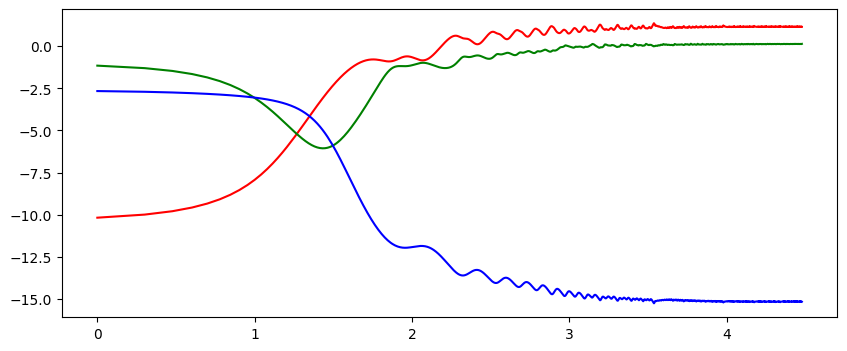

[  1.15047187   0.13865879 -15.16659357]
1.1504718680628578


In [ ]:
#The recipe:
x0 = [1,1,1]
T = 6500
dt = 0.005
N = int(T/dt)
times = np.linspace(0,T,N)
sol = solve_ivp(F, [0,T], x0, t_eval=times).y #old version: odeint(F,X0[i],times)
n = 30000
N0 = 2000
lambdas = np.zeros([n,3])
Q = np.eye(3)
for i in range(1,n):
 M = np.eye(3) + jacobian(sol[0,N0+i],sol[1,N0+i],sol[2,N0+i])*dt
 Qnew,Rnew = np.linalg.qr(np.matmul(M,Q))
 lambdas[i,:] = lambdas[i-1,:] + np.log(np.abs(Rnew.diagonal()))
 #lambdas[i,:] = lambdas[i,:]
 Q = Qnew.copy()


colors = ['r','g','b']
for j in range(3):
 lambdas[:,j] = lambdas[:,j]/(np.arange(0,n,1)*dt)
 plt.plot(np.log10(np.arange(0,n,1)),lambdas[:,j],color=colors[j])
plt.show()
print(lambdas[-1,:])

lambda_1 = lambdas[-1,0]
print(lambda_1)
dt =.02

### Train Reservoir

In [ ]:
res = Reservoir(rho=0.1)

#train on data
res.clear_memory()
_,S,_ = np.linalg.svd(res.W)
print(np.amax(S))

res.train(X_train,verbose=True)

0.10000000000000005
iteration:8999/8999
computing...
done!


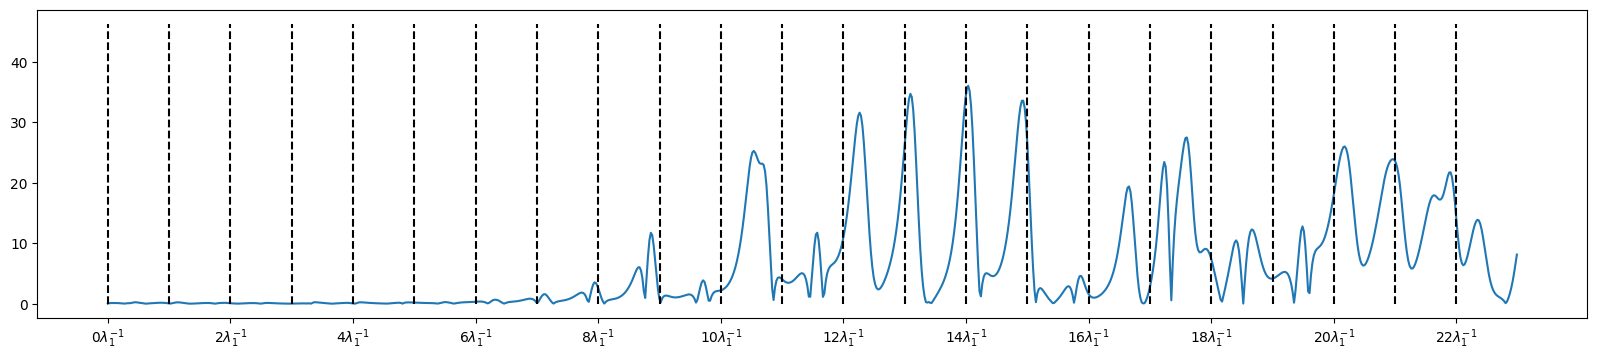

In [ ]:
X_pred = np.zeros(X_val.shape)
X_pred[:,0] = X_val[:,0]
for t in range(1,X_val.shape[1]):
  X_pred[:,t] = res.step(X_pred[:,t-1]).reshape(3)

I = np.arange(0,int(X_pred.shape[1]*dt),dt)
plt.rcParams['figure.figsize'] = [20,4]
plt.plot(I, np.abs(X_pred[1,:] - X_val[1,:])) #abs(x2_pred - x2_real)
for t in np.arange(0,I[-1],1/lambda_1):
  plt.plot(t*np.ones(2), [0,X_pred.max()],'k--')

ticks = np.arange(0,I[-1],2/lambda_1)
plt.xticks(ticks,[f"{2*i}"+r"$\lambda_1^{-1}$" for i in range(len(ticks))])
plt.show()

In [ ]:
x_1 = np.array([2,2,2])
x_2 = np.array([2.001,2.001,2.001])

res.clear_memory()
T = 10**3
y_1 = x_1
for t in range(1,int(T/dt)):y_1 = res.step(y_1)

res.clear_memory()
y_2 = x_2
for t in range(1,int(T/dt)):y_2 = res.step(y_2)

lamb = np.log(np.linalg.norm(y_2 - y_1)/np.linalg.norm(x_2 - x_1))/T
print(lamb)


0.07183250471380939


The maximal Lyapunov exponent $\lambda_{1}$ characterizes the large-time average exponential growth or contraction rate of separations $\delta(t)$ between two close-by particles:
$$\lambda_{1}\equiv \lim_{ \delta(0) \to 0 } \lim_{ t \to \infty } \frac{1}{t}\ln{\frac{\lvert\delta(t)\rvert}{\lvert\delta(0)\rvert}}$$
$\lambda_{1}$ determines sensitivity to initial conditions.
$\frac{1}{\lambda_{1}}$ is the lyapunov time and determines how long a system is predictable.